# keras embedding을 이용한 문서 분류
### 영화리뷰 데이터 대상

## train set의 크기가 더 큰 데이터 셋, 그리고 한글

In [1]:
import csv

text = []
y = []
with open('movie_data_new.csv', encoding='utf-8') as csvfile:
    csvreader = csv.reader(csvfile)
    for row in csvreader:
        #print(row)
        if row: #그 줄에 내용이 있는 경우에만
            text.append(row[0]) #영화 리뷰를 text 리스트에 추가
            y.append(row[2]) #영화이름을 text 리스트에 추가

In [2]:
print('Num of samples: {}'.format(len(text)))
print('Movie titles of reivews: {}'.format(set(y)))

Num of samples: 14967
Movie titles of reivews: {'라라랜드', '곤지암', '범죄도시', '택시운전사', '코코', '신과함께', '인피니티 워'}


In [3]:
label_dict = dict(zip(set(y),range(len(set(y)))))
y = [label_dict[c] for c in y]
print(len(y))
print(y[-10:])

14967
[4, 4, 4, 4, 4, 4, 4, 4, 4, 4]


In [4]:
from keras.utils.np_utils import to_categorical
y = to_categorical(y)

Using TensorFlow backend.


In [5]:
from konlpy.tag import Okt #konlpy에서 Twitter 형태소 분석기를 import
#from konlpy.tag import Twitter #konlpy에서 Twitter 형태소 분석기를 import
twitter_tag = Okt()
#twitter_tag = Twitter()

In [19]:
print(twitter_tag.nouns(text[4]))

['내', '졸라']


In [7]:
from seqGenKor import SequenceGenKor

In [20]:
num_words = 10000
seq = SequenceGenKor(twitter_tag.nouns, num_words=num_words, min_token_len=1)
#seq = SequenceGenKor(twitter_tag.morphs, num_words=num_words, min_token_len=1)
seq.fit_on_texts(text)
X = seq.texts_to_sequences(text)
print('voca_size', len(seq.voca))

voca_size 10380


In [21]:
print(X[:12])

[[412, 1296, 1120], [387, 115], [5437], [274, 1121, 984, 64, 1231, 1579, 342, 534, 3200, 243], [36, 1122], [109], [5, 413, 71], [71, 149], [19, 331, 3201, 736, 2409], [101, 198, 3992], [9], [91, 5438]]


In [22]:
text[:12]

['헐..다 죽었어....나중에 앤트맨 보다가도 깜놀...',
 '충격 결말',
 '응집력',
 '개연성은 무시해라 액션을 즐겨라 스타로드가 이끌어준다 각각의 영웅들을 즐겨라 그리고 단적인 신념이 얼마나 부질없는지 보셔라',
 '내가졸라이상하네',
 '대박',
 '정말 지루할틈없이 넘잘만들었다 역시 대단하다',
 '역시 어벤져스!!',
 '마지막에 누구한테 연락한거지? 궁금',
 '다음 편이 궁굼해지네요^^',
 '안잼있는사람 있음???????????',
 '타노스 개갞기']

In [23]:
from keras import preprocessing

maxlen = 20

X = preprocessing.sequence.pad_sequences(X, maxlen=maxlen, truncating='pre')
print(X[0])

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0  412 1296 1120]


In [24]:
from sklearn.model_selection import train_test_split #sklearn에서 제공하는 split 함수를 사용
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)
# sklearn의 train_test_split 함수는 먼저 data set을 shuffle하고 주어진 비율에 따라 train set과 test set을 나눠 줌
# 위에서는 reviews를 X_train과 X_test로 8:2의 비율로 나누고, categories를 y_train과 y_test로 나눔
# 이 때 X와 y의 순서는 동일하게 유지해서 각 입력값과 label이 정확하게 match되도록 함
# random_state는 shuffle에서의 seed 값으로, 지정한 경우 항상 동일한 결과로 shuffle이 됨

print('Train set count:', len(X_train))
print('Test set count:', len(X_test))
print('Test samples:', y_test[:20])

Train set count: 11973
Test set count: 2994
Test samples: [[0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1. 0.]]


In [25]:
from keras.layers import SimpleRNN, LSTM
from keras.models import Sequential
from keras.layers import Flatten, Dense, Embedding

model = Sequential()
model.add(Embedding(num_words, 32))
#model.add(SimpleRNN(32))
model.add(LSTM(32))
model.add(Dense(7, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_2 (Dense)              (None, 7)                 231       
Total params: 328,551
Trainable params: 328,551
Non-trainable params: 0
_________________________________________________________________


In [26]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])

history = model.fit(X_train, y_train, 
                    epochs=30,
                    batch_size=256,
                    validation_split=0.2)

Train on 9578 samples, validate on 2395 samples
Epoch 1/30
9578/9578 [==============================] - 3s 288us/step - loss: 1.8199 - acc: 0.3287 - val_loss: 1.7509 - val_acc: 0.3365
Epoch 2/30
9578/9578 [==============================] - 2s 176us/step - loss: 1.7051 - acc: 0.3439 - val_loss: 1.6461 - val_acc: 0.3624
Epoch 3/30
9578/9578 [==============================] - 2s 181us/step - loss: 1.5814 - acc: 0.4026 - val_loss: 1.5584 - val_acc: 0.4180
Epoch 4/30
9578/9578 [==============================] - 2s 188us/step - loss: 1.4743 - acc: 0.4428 - val_loss: 1.4830 - val_acc: 0.4397
Epoch 5/30
9578/9578 [==============================] - 2s 180us/step - loss: 1.3397 - acc: 0.4930 - val_loss: 1.3519 - val_acc: 0.5136
Epoch 6/30
9578/9578 [==============================] - 2s 211us/step - loss: 1.2113 - acc: 0.5534 - val_loss: 1.2712 - val_acc: 0.5541
Epoch 7/30
9578/9578 [==============================] - 2s 228us/step - loss: 1.1109 - acc: 0.6087 - val_loss: 1.2202 - val_acc: 0.5850


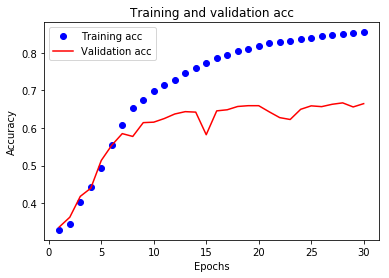

In [27]:
%matplotlib inline
import matplotlib.pyplot as plt

history_dict = history.history
acc = history_dict['acc']
val_acc = history_dict['val_acc']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [28]:
score = model.evaluate(X_test, y_test)
print(score)

2994/2994 [==============================] - 0s 104us/step
[1.1868019432088257, 0.6583166334257973]
